In [ ]:
"""
1. Напишіть код для визначення границь та кутів у зображенні за допомогою фільтра Собеля.

2. Використовуючи метод густини градієнта (HOG), напишіть код для витягування ознак з зображення.

3. Завантажте датасет CIFAR-10 та використайте HOG для витягування ознак зображень. 
Застосуйте будь-який простий класифікатор (наприклад, SVM) для класифікації зображень та обчисліть метрики точності, 
такі як **accuracy, precision, recall та F1-score.

4. Використайте метод SIFT для витягування ознак з зображень та порівняйте його з методом HOG за допомогою метрик точності.
"""

In [13]:
#!pip install tensorflow

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from skimage import color
from tensorflow.keras.datasets import cifar10
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

## 1. Визначення границь та кутів у зображенні за допомогою фільтра Собеля. 

In [2]:
img = cv2.imread('auto.jpg')

In [3]:
# Перетворення на чорно-біле
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Детектор країв градієнта
sobelx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)

# Розрахунок абсолютної величини градієнта
abs_sobelx = cv2.convertScaleAbs(sobelx)
abs_sobely = cv2.convertScaleAbs(sobely)
grad = cv2.addWeighted(abs_sobelx, 0.5, abs_sobely, 0.5, 0)

# Означення кутів
angle = cv2.phase(sobelx, sobely, angleInDegrees=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


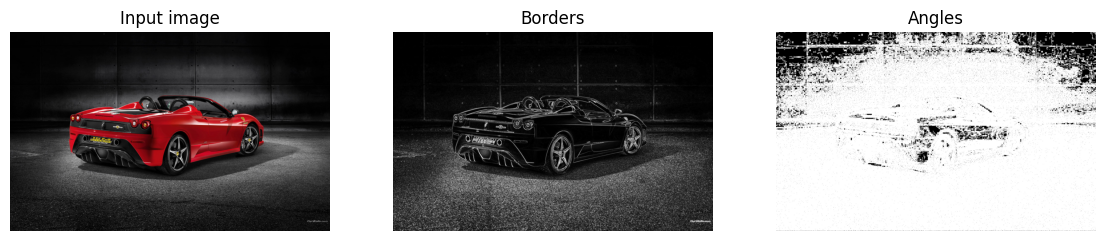

In [4]:
# Порівняння зображень
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
grad1 = cv2.cvtColor(grad, cv2.COLOR_BGR2RGB)
angle1 = cv2.cvtColor(angle, cv2.COLOR_BGR2RGB)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 7), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img1, cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(grad1, cmap=plt.cm.gray)
ax2.set_title('Borders')

ax3.axis('off')
ax3.imshow(angle1, cmap=plt.cm.gray)
ax3.set_title('Angles')
plt.show()

## 2. Витягування ознак з зображення з використанням методу густини градієнта (HOG) 

In [5]:
from skimage.feature import hog
from skimage import data, exposure

HOG для кольорового зображення

In [6]:
image = cv2.imread('auto.jpg')

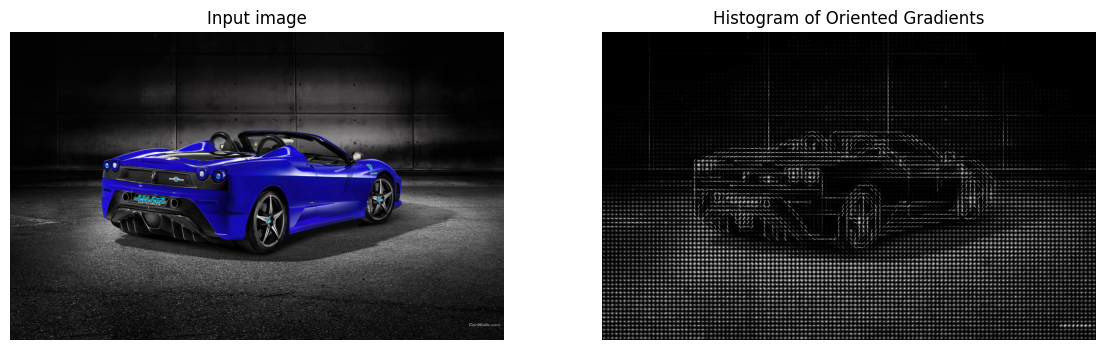

In [7]:
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Зміна масштабу гістограми для кращого відображення
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

HOG для чорно-білого зображення

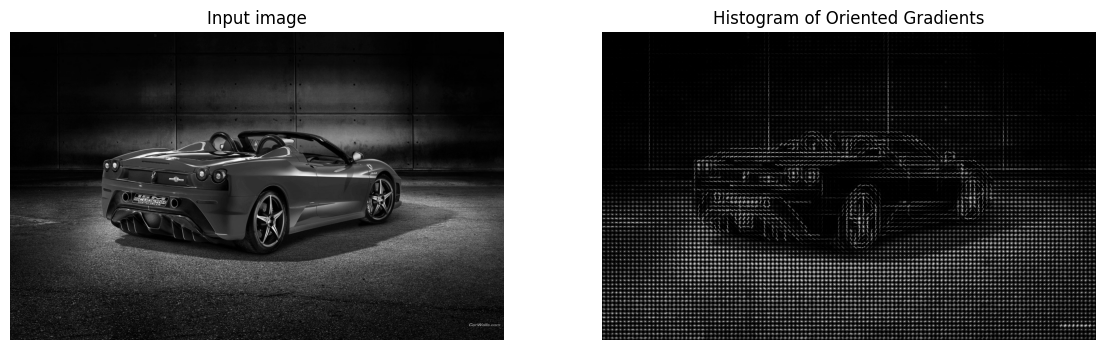

In [8]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
fd, hog_image = hog(gray, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(gray, cmap=plt.cm.gray)
ax1.set_title('Input image')

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

## 3. Використання HOG для витягування ознак зображень 

In [14]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 77s 0us/step


In [15]:
train_data_gray = np.array([cv2.cvtColor(x.reshape(32, 32, 3), cv2.COLOR_BGR2GRAY) for x in x_train])
test_data_gray = np.array([cv2.cvtColor(x.reshape(32, 32, 3), cv2.COLOR_BGR2GRAY) for x in x_test])

In [17]:
train_hog_features = np.array([hog(x, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False) for x in train_data_gray])
test_hog_features = np.array([hog(x, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False) for x in test_data_gray])

In [18]:
pca = PCA(n_components=200, random_state=42)
train_pca_features = pca.fit_transform(train_hog_features)
test_pca_features = pca.transform(test_hog_features)

In [19]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [20]:
clf = SVC(kernel='rbf')
clf.fit(train_pca_features, y_train)

SVC()

In [21]:
y_pred = clf.predict(test_pca_features)

In [22]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1-Score:', f1)

Accuracy: 0.626
Precision: 0.6249679364491738
Recall: 0.626
F1-Score: 0.6246989635968799


## 4. Використання методу SIFT для витягування ознак з зображень 

In [23]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [24]:
x_train_gray = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in x_train])
x_test_gray = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in x_test])

In [25]:
sift = cv2.SIFT_create()

In [26]:
sift_train_features = []
sift_train_labels = []
for i in range(len(x_train_gray)):
    keypoints, descriptors = sift.detectAndCompute(x_train_gray[i], None)
    if descriptors is not None:
        sift_train_features.append(descriptors)
        sift_train_labels.append(y_train[i])

In [27]:
sift_test_features = []
sift_test_labels = []
for i in range(len(x_test_gray)):
    keypoints, descriptors = sift.detectAndCompute(x_test_gray[i], None)
    if descriptors is not None:
        sift_test_features.append(descriptors)
        sift_test_labels.append(y_test[i])

In [28]:
max_descriptors = max([len(desc) for desc in sift_train_features])
sift_train_features_arr = np.zeros((len(sift_train_features), max_descriptors, 128))
for i in range(len(sift_train_features)):
    for j in range(len(sift_train_features[i])):
        sift_train_features_arr[i][j] = sift_train_features[i][j]

In [29]:
max_descriptors = max([len(desc) for desc in sift_test_features])
sift_test_features_arr = np.zeros((len(sift_test_features), max_descriptors, 128))
for i in range(len(sift_test_features)):
    for j in range(len(sift_test_features[i])):
        sift_test_features_arr[i][j] = sift_test_features[i][j]

In [30]:
new_sift_train_features_arr = sift_train_features_arr.reshape(len(sift_train_features_arr), -1)
new_sift_test_features_arr = sift_test_features_arr.reshape(len(sift_test_features_arr), -1)

In [31]:
pca = PCA(n_components=200)
train_pca_features_shift = pca.fit_transform(new_sift_train_features_arr)
test_pca_features_shift = pca.fit_transform(new_sift_test_features_arr)

In [32]:
new_sift_train_labels = []
for i in sift_train_labels:
  new_sift_train_labels.append(i[0])

In [33]:
new_sift_test_labels = []
for i in sift_test_labels:
  new_sift_test_labels.append(i[0])

In [34]:
clf = SVC(kernel='rbf')
clf.fit(train_pca_features_shift, new_sift_train_labels)

SVC()

In [35]:
y_pred = clf.predict(test_pca_features_shift)

In [36]:
accuracy = accuracy_score(new_sift_test_labels, y_pred)
precision = precision_score(new_sift_test_labels, y_pred, average='macro')
recall = recall_score(new_sift_test_labels, y_pred, average='macro')
f1 = f1_score(new_sift_test_labels, y_pred, average='macro')


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.19135926222935043
Precision: 0.18896975381914732
Recall: 0.19143765810812702
F1-score: 0.18913563066488887


При використанні методу HOG для витягування ознак з зображень точніть вийшла 0.626 а з методом SIFT 0.191. Отже, для даного датасету метод HOG працює дещо краще.